In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

In [2]:
class UNetDenoise(nn.Module):
    #layers definition
    def __init__(self): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        #1st downsample layer
        self.conv11 = nn.Conv2d(3,64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half 
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        #output layer
        self.outconv = nn.Conv2d(64, 1, kernel_size=1) #2 classes: 0=not car, 1=car

    def forward(self, x):
        #encoder forward
        xconv11 = relu(self.conv11(x))
        xconv12 = relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = relu(self.conv21(xpool1))
        xconv22 = relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = relu(self.conv31(xpool2))
        xconv32 = relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = relu(self.conv41(xpool3))
        xconv42 = relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = relu(self.conv51(xpool4))
        xconv52 = relu(self.conv52(xconv51))

        #decoder forward 
        xup1 = self.upconv1(xconv52)
        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = relu(self.u11(xu11))
        xd12 = relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = relu(self.u21(xu22))
        xd22 = relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = relu(self.u31(xu33))
        xd32 = relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = relu(self.u41(xu44))
        xd42 = relu(self.u42(xd41))

        #output layer
        out = self.outconv(xd42)
        return out

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [4]:
model1 = UNetDenoise()
model1.load_state_dict(torch.load('carSegmentationMed.pth'))
model1.eval()
model1.to(device)


UNetDenoise(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv51

In [5]:
#dataLoader to handle mask-image pairs

class SegmentationDataset():
    def __init__(self, testSet=False, transform=None, transformMask=None):
        self.transform = transform
        self.transformMask = transformMask
        if testSet:
            self.image_dir = 'carvanaTestMed/'
            self.mask_dir = 'carvanaTestMaskMed/'
        else:
            self.image_dir = 'carvanaTrainMed/'
            self.mask_dir = 'carvanaTrainMaskMed/'
        self.images = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '_mask.gif'))  # Assuming masks have .gif extension
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale mask

        if self.transform:
            image = self.transform(image)
            mask = self.transformMask(mask)
        #mask = torch.tensor(np.array(mask), dtype=torch.long)
        return image, mask

In [6]:
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

preprocessMask = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

In [7]:
test_datset = SegmentationDataset(testSet=True, transform=preprocess, transformMask=preprocessMask)

In [8]:
test_loader = DataLoader(test_datset, batch_size=10, shuffle=True)

In [9]:
#Dice score as loss function
class DiceLoss(torch.nn.Module):
    def __init__(self, epsilon=1e-6):
        super(DiceLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, predicted, target):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice_score = (2 * intersection + self.epsilon) / (union + self.epsilon)
        return 1 - dice_score

In [10]:
def diceScore(predicted, target, epsilon=1e-6):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice_score = (2 * intersection + epsilon) / (union + epsilon)
    return dice_score

In [11]:
def normalizeOutputMask(mask):
    min_value = np.min(mask.squeeze(0).cpu().numpy())
    max_value = np.max(mask.squeeze(0).cpu().numpy())
    return (mask - min_value) / (max_value - min_value)

In [12]:

criterion = nn.BCEWithLogitsLoss()

In [13]:
losslist=list()
diceScores = list()
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model1(images)
        loss=criterion(outputs, masks)
        losslist.append(loss)
        binary_masks = (outputs > 0.0).float()
        dice = diceScore(binary_masks, masks)
        diceScores.append(dice)

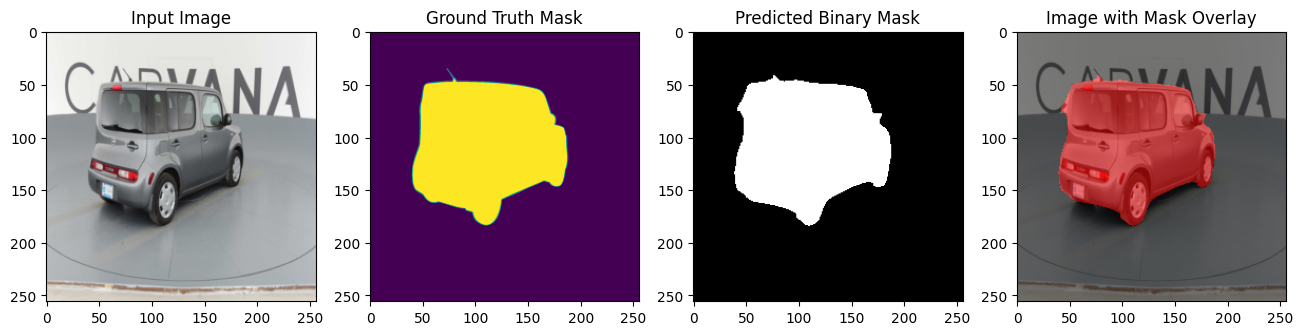

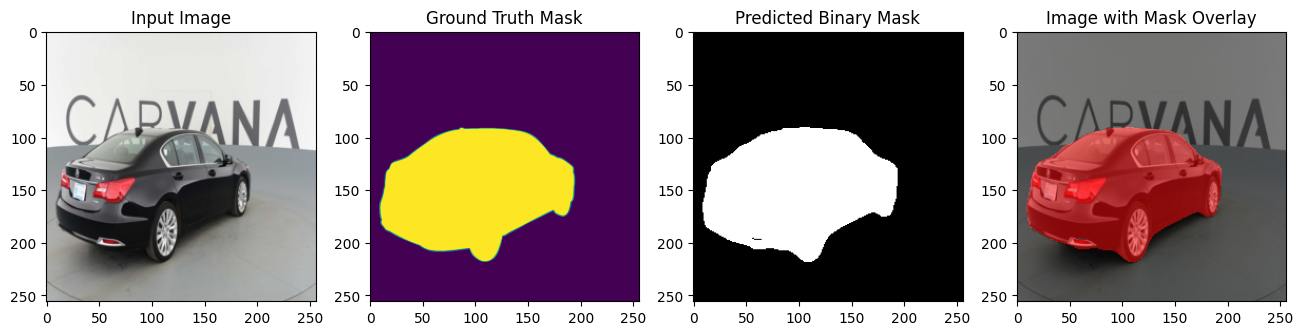

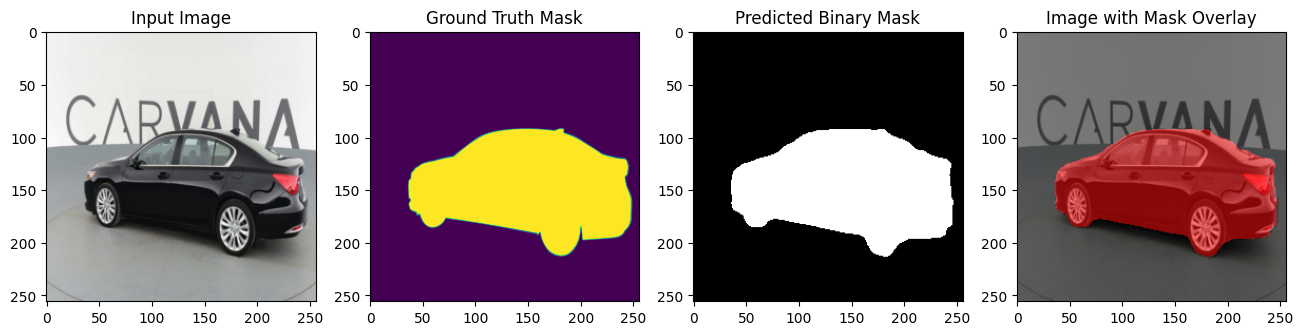

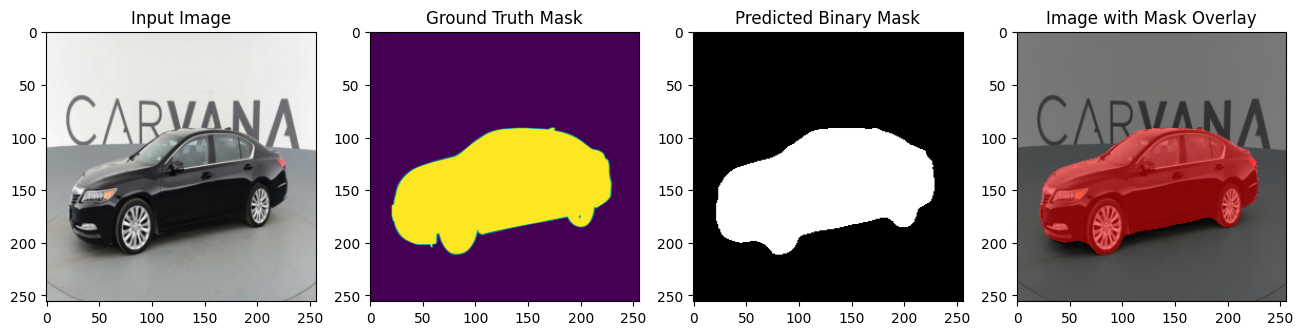

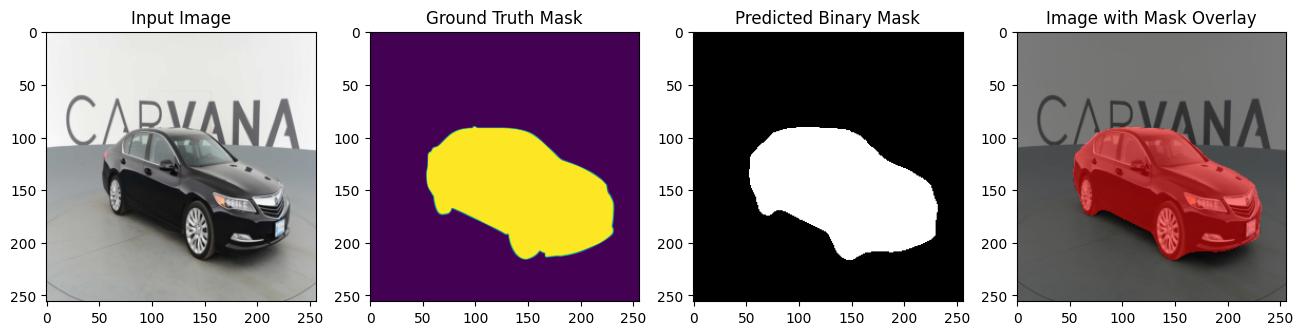

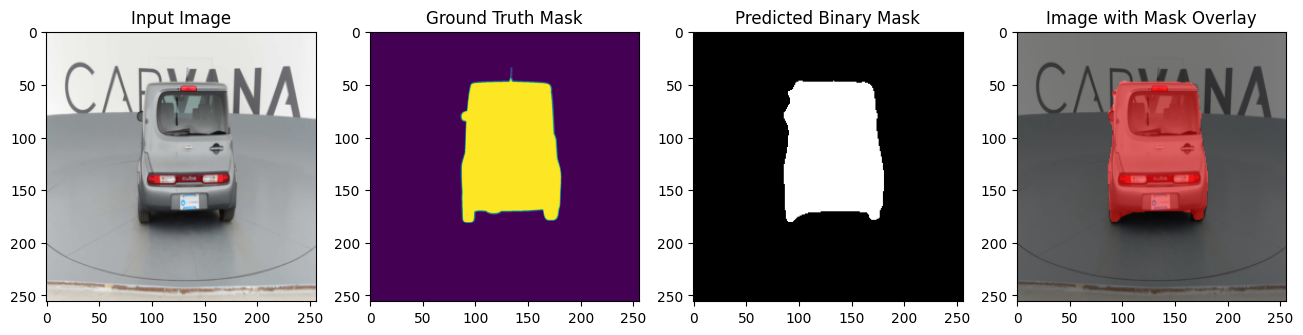

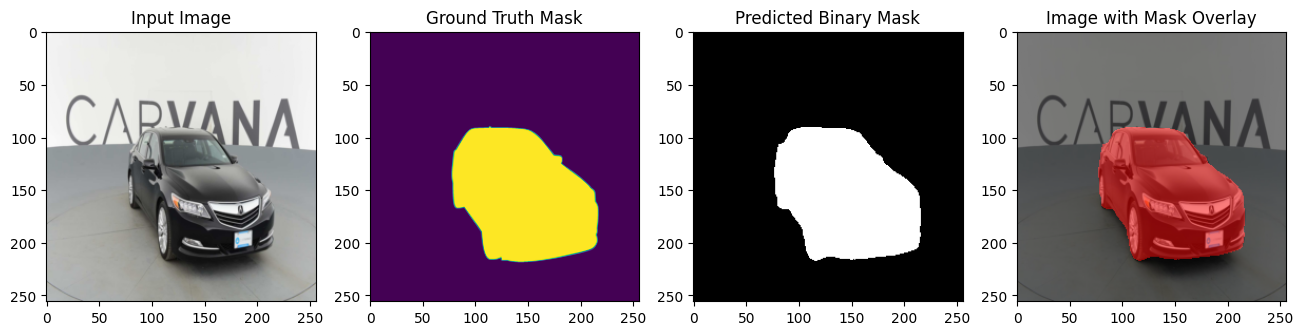

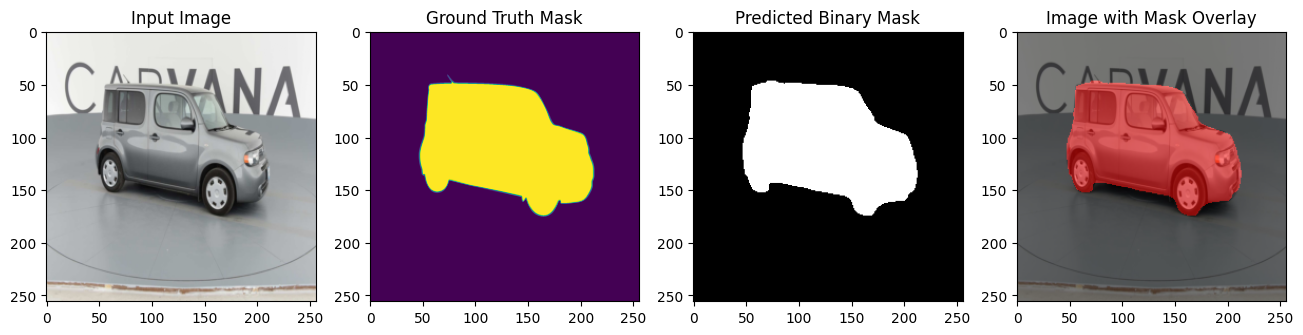

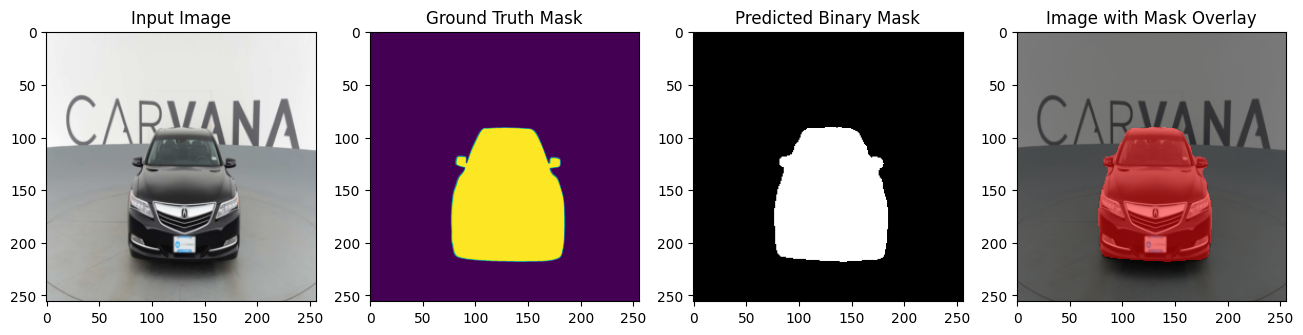

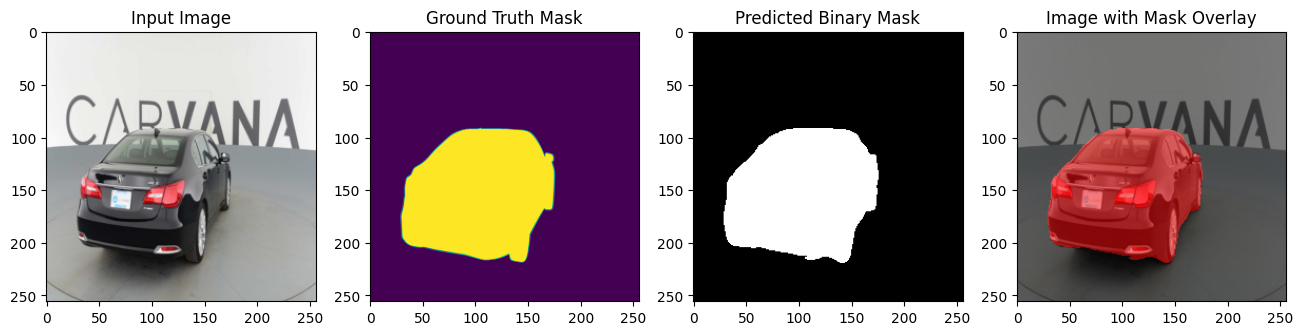

In [14]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(10):
    images_np = images.cpu().numpy()
    output_np = outputs.cpu().numpy()
    masks_np = masks.cpu().numpy()

    anImage = images_np[i].transpose(1, 2, 0)
    anMask = masks_np[i].transpose(1, 2, 0)[:, :, 0]  # Assuming mask is single-channel
    anOutput = output_np[i]

    threshold = 0.0
    binary_mask = (anOutput > threshold).astype(float)  # Create binary mask
    binary_mask = binary_mask[0]  # Ensure this is 2D if it's not

    # Superimpose the binary mask onto the image using a color overlay
    colored_mask = np.zeros_like(anImage)
    colored_mask[binary_mask > 0] = [1, 0, 0]  # Red color for mask

    # Mix image and colored mask
    alpha = 0.5  # Transparency factor.
    maskOnImage = (1 - alpha) * anImage + alpha * colored_mask

    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(anImage)
    axes[0].set_title('Input Image')
    axes[1].imshow(anMask)
    axes[1].set_title('Ground Truth Mask')
    axes[2].imshow(binary_mask, cmap='gray')
    axes[2].set_title('Predicted Binary Mask')
    axes[3].imshow(maskOnImage)
    axes[3].set_title('Image with Mask Overlay')

    plt.show()


In [15]:
avgDiceScore = sum(diceScores)/len(diceScores)

In [16]:
avgDiceScore.item()

0.9863815307617188